# 02 - Model Site Performance
This notebook trains and evaluates machine learning models to predict clinical trial site success based on metadata from the AACT dataset.

## 1. Load and Inspect Dataset
Load the cleaned dataset created in the previous step and examine the structure, missing values, and feature types.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../data/site_performance.csv")
print(f"Dataset shape: {df.shape}")
#df.head()

#df.describe()

#find all null calues in df
null_values = df.isnull().sum()

print(null_values)

Dataset shape: (3285407, 13)
nct_id                   0
name                220050
city                   111
state              1323857
country                  0
study_type               0
phase                    0
enrollment           36013
overall_status           0
agency_class             0
condition_count          0
site_count               0
site_success             0
dtype: int64


### Summary Statistics and Class Distribution
View key statistics and check for class imbalance in the `site_success` label.

<Axes: title={'center': 'Class Distribution (Site Success)'}, xlabel='site_success'>

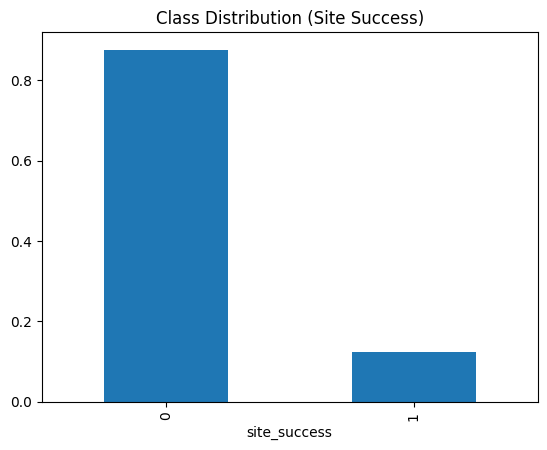

In [2]:
df.describe(include='all')
df['site_success'].value_counts(normalize=True).plot(kind='bar', title="Class Distribution (Site Success)")

## 2. Data Preprocessing
Handle missing values, encode categorical variables, and scale numerical features where appropriate.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Select features and target
target = "site_success"
features = [
    "study_type", "phase", "country", "agency_class", 
    "enrollment", "condition_count", "site_count"
]

X = df[features]
y = df[target]

# Identify categorical and numeric columns
cat_features = ["study_type", "phase", "country", "agency_class"]
num_features = ["enrollment", "condition_count", "site_count"]

# Define transformers
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## 3. Model Training and Evaluation
Train a Random Forest, XGBoost, and Logistic Regression classifier. Evaluate each model using accuracy, precision, recall, F1-score, and ROC-AUC.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = {}

for name, clf in classifiers.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

    results[name] = {
        "pipeline": pipe,
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

## 4. Feature Importance (Random Forest)
Extract and plot feature importance values from the Random Forest model to understand which features contribute most to prediction.

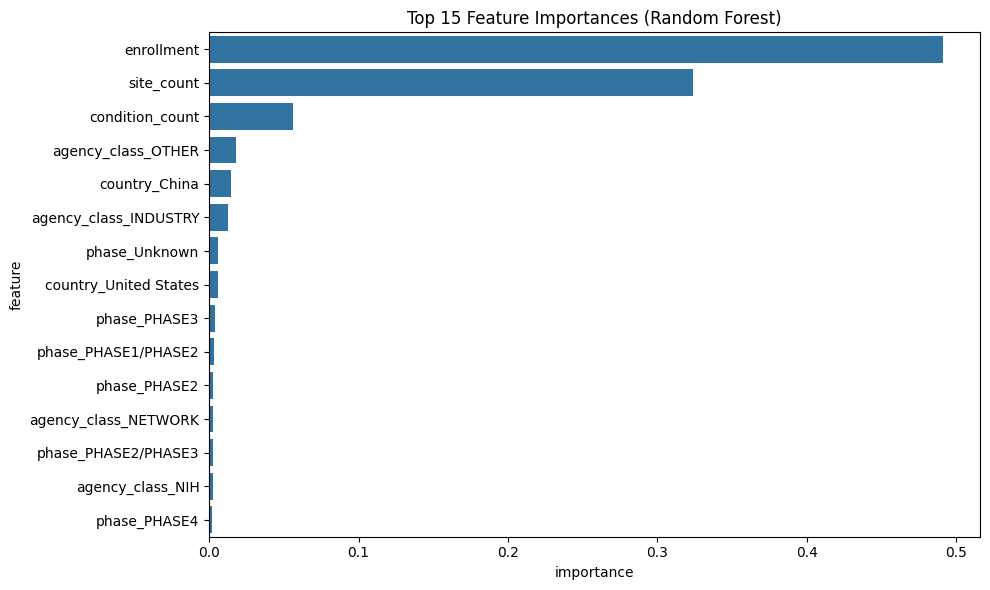

In [5]:
# Get feature names after preprocessing
rf_model = results["Random Forest"]["pipeline"]
feature_names = (
    rf_model.named_steps["preprocessor"].transformers_[0][2] + 
    list(
        rf_model.named_steps["preprocessor"]
        .transformers_[1][1]
        .named_steps["onehot"]
        .get_feature_names_out(cat_features)
    )
)

importances = rf_model.named_steps["classifier"].feature_importances_
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp_df = feat_imp_df.sort_values(by="importance", ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_imp_df)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

## 5. Save Best Model
Persist the best performing model (by ROC-AUC) for later use in a Streamlit dashboard or API.

In [7]:
import joblib

# Choose best model by ROC-AUC
best_model_name = max(results, key=lambda name: results[name]["roc_auc"])
best_pipeline = results[best_model_name]["pipeline"]

joblib.dump(best_pipeline, f"../models/site_success_model_{best_model_name.replace(' ', '_')}.joblib")
print(f"Saved best model: {best_model_name}")

Saved best model: Random Forest
